# Ch5. Multiple Regression Analysis: OLS Asymptotics

In [1]:
%pip install matplotlib numpy statsmodels wooldridge scipy -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import wooldridge as woo
from scipy import stats

## 5.1 Simulation Exercises

### 5.1.1 Normally Distributed Error Terms

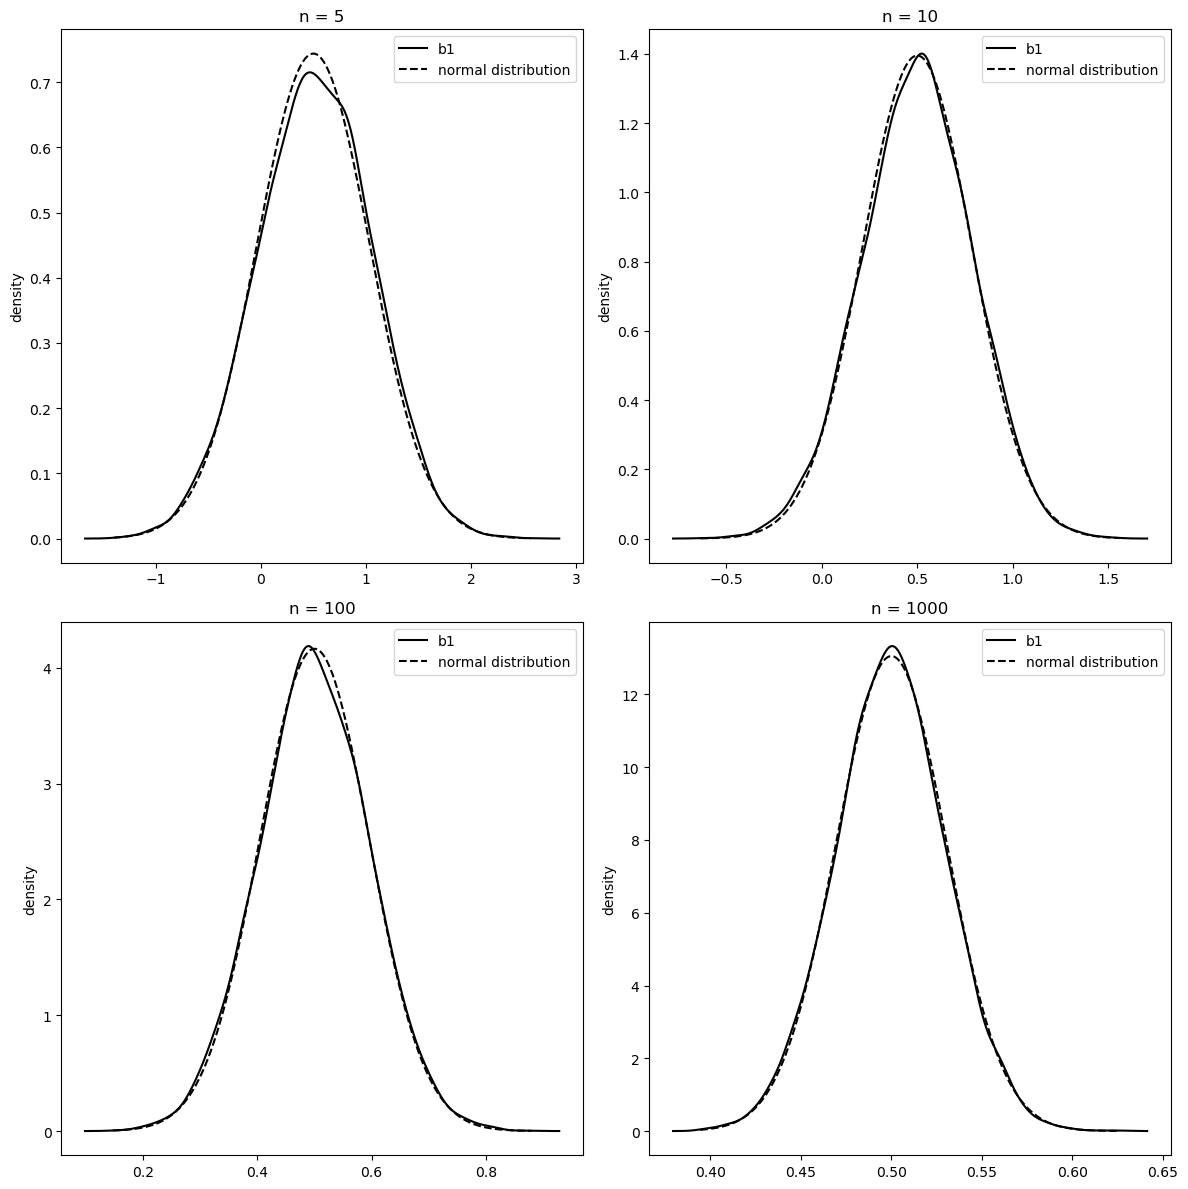

In [3]:
# set the random seed:
np.random.seed(1234567)

# set sample size and number of simulations:
n = [5, 10, 100, 1000]
r = 10000

# set true parameters:
beta0 = 1
beta1 = 0.5
sx = 1
ex = 4

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the 2x2 array for easier indexing

for idx, j in enumerate(n):
    # draw a sample of x, fixed over replications:
    x = stats.norm.rvs(ex, sx, size=j)
    # draw a sample of u (std. normal)
    u = stats.norm.rvs(0, 1, size=(r, j))

    # Compute y for all replications at once
    y = beta0 + beta1 * x + u

    # Create design matrix X
    X = np.column_stack((np.ones(j), x))

    # Compute (X'X)^(-1)X' once
    XX_inv = np.linalg.inv(X.T @ X)
    XTX_inv_XT = XX_inv @ X.T

    # Estimate beta for all replications at once
    b = XTX_inv_XT @ y.T
    b1 = b[1, :]  # Extract all b1 estimates

    # simulated density:
    kde = sm.nonparametric.KDEUnivariate(b1)
    kde.fit()

    # normal density/ compute mu and se
    Vbhat = sx * XX_inv
    se = np.sqrt(np.diagonal(Vbhat))
    x_range = np.linspace(min(b1), max(b1), 1000)
    y = stats.norm.pdf(x_range, beta1, se[1])

    # plotting:
    axs[idx].plot(kde.support, kde.density, color="black", label="b1")
    axs[idx].plot(
        x_range,
        y,
        linestyle="--",
        color="black",
        label="normal distribution",
    )
    axs[idx].set_ylabel("density")
    axs[idx].set_xlabel("")
    axs[idx].legend()
    axs[idx].set_title(f"n = {j}")

plt.tight_layout()
plt.show()

### 5.1.2 Non-Normal Error Terms

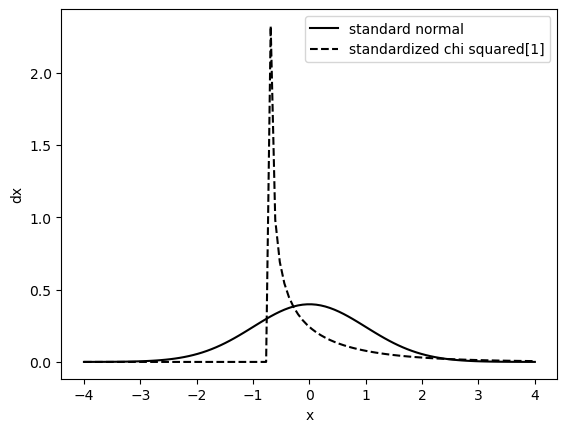

In [4]:
# support of normal density:
x_range = np.linspace(-4, 4, num=100)

# pdf for all these values:
pdf_n = stats.norm.pdf(x_range)
pdf_c = stats.chi2.pdf(x_range * np.sqrt(2) + 1, 1)
# pdf_c = (stats.chi2.pdf(x_range,1) - 1) / np.sqrt(2)
# plot:
plt.plot(x_range, pdf_n, linestyle="-", color="black", label="standard normal")
plt.plot(
    x_range,
    pdf_c,
    linestyle="--",
    color="black",
    label="standardized chi squared[1]",
)
plt.xlabel("x")
plt.ylabel("dx")
plt.legend()

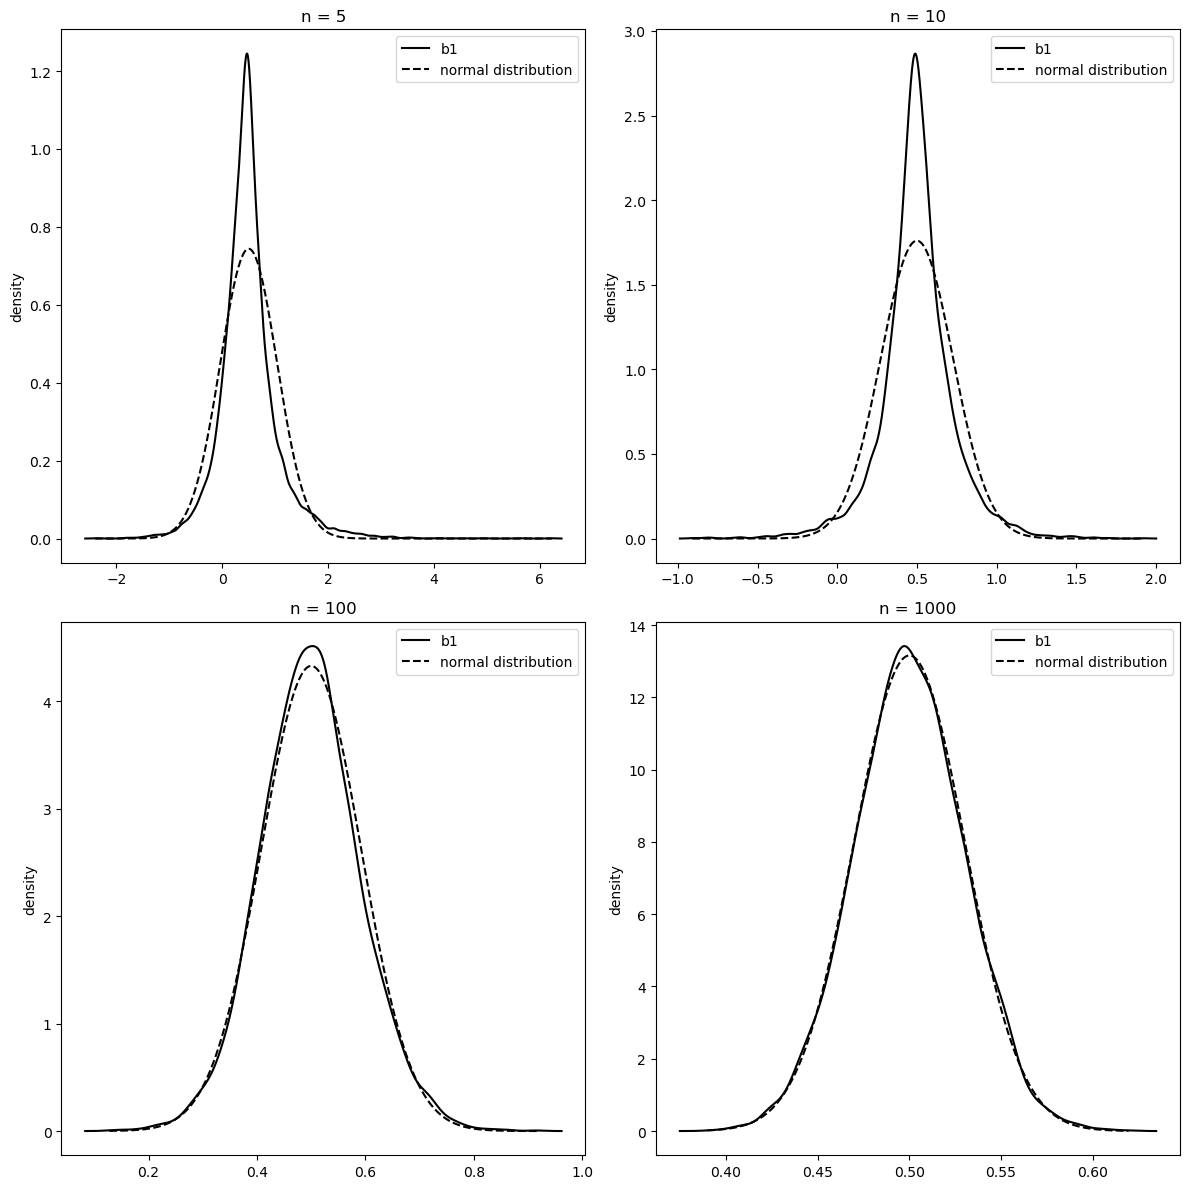

In [5]:
# set the random seed:
np.random.seed(1234567)

# set sample size and number of simulations:
n = [5, 10, 100, 1000]
r = 10000

# set true parameters:
beta0 = 1
beta1 = 0.5
sx = 1
ex = 4

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the 2x2 array for easier indexing

for idx, j in enumerate(n):
    # draw a sample of x, fixed over replications:
    x = stats.norm.rvs(ex, sx, size=j)

    # Create design matrix X
    X = np.column_stack((np.ones(j), x))

    # Compute (X'X)^(-1)X' once
    XX_inv = np.linalg.inv(X.T @ X)
    XTX_inv_XT = XX_inv @ X.T

    # Generate all error terms at once
    u = (stats.chi2.rvs(1, size=(r, j)) - 1) / np.sqrt(2)

    # Compute y for all replications at once
    y = beta0 + beta1 * x + u

    # Estimate beta for all replications at once
    b = XTX_inv_XT @ y.T
    b1 = b[1, :]  # Extract all b1 estimates

    # simulated density:
    kde = sm.nonparametric.KDEUnivariate(b1)
    kde.fit()

    # normal density/ compute mu and se
    Vbhat = sx * XX_inv
    se = np.sqrt(np.diagonal(Vbhat))
    x_range = np.linspace(min(b1), max(b1), 1000)
    y = stats.norm.pdf(x_range, beta1, se[1])

    # plotting:
    axs[idx].plot(kde.support, kde.density, color="black", label="b1")
    axs[idx].plot(
        x_range,
        y,
        linestyle="--",
        color="black",
        label="normal distribution",
    )
    axs[idx].set_ylabel("density")
    axs[idx].set_xlabel("")
    axs[idx].legend()
    axs[idx].set_title(f"n = {j}")

plt.tight_layout()
plt.show()

### 5.1.3 (Not) Conditioning on the Regressors

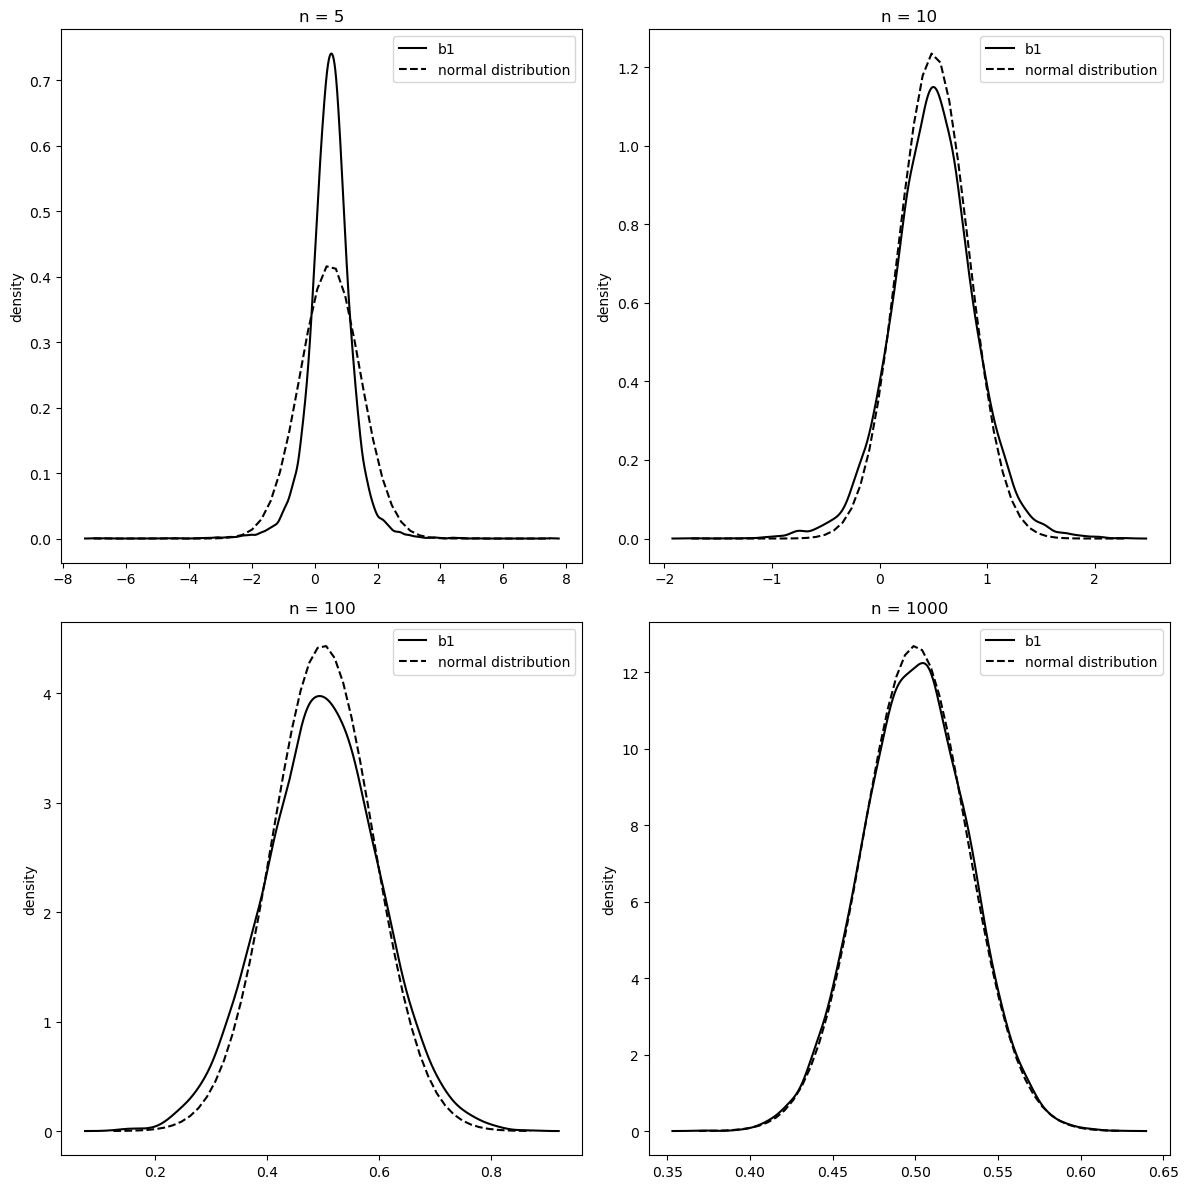

In [6]:
# set the random seed:
np.random.seed(1234567)

# set sample size and number of simulations:
n = [5, 10, 100, 1000]
r = 10000

# set true parameters:
beta0 = 1
beta1 = 0.5
sx = 1
ex = 4

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the 2x2 array for easier indexing

for idx, j in enumerate(n):
    # initialize b1 to store results later:
    b1 = np.empty(r)

    # draw a sample of x, varying over replications:
    x = stats.norm.rvs(ex, sx, size=(r, j))
    # draw a sample of u (std. normal):
    u = stats.norm.rvs(0, 1, size=(r, j))
    y = beta0 + beta1 * x + u
    # repeat r times:
    for i in range(r):
        # Create design matrix X
        X = np.column_stack((np.ones(j), x[i]))

        # Compute (X'X)^(-1)X' once
        XX_inv = np.linalg.inv(X.T @ X)
        XTX_inv_XT = XX_inv @ X.T

        # Estimate beta for all replications at once
        b = XTX_inv_XT @ y[i].T
        b1[i] = b[1]

    # simulated density:
    kde = sm.nonparametric.KDEUnivariate(b1)
    kde.fit()
    # normal density/ compute mu and se
    Vbhat = sx * np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diagonal(Vbhat))
    x_range = np.linspace(min(b1), max(b1))
    y = stats.norm.pdf(x_range, beta1, se[1])
    # plotting:
    # plt.ylim(top=2)
    # plt.xlim(8.5, 11.5)
    # plotting:
    axs[idx].plot(kde.support, kde.density, color="black", label="b1")
    axs[idx].plot(
        x_range,
        y,
        linestyle="--",
        color="black",
        label="normal distribution",
    )
    axs[idx].set_ylabel("density")
    axs[idx].set_xlabel("")
    axs[idx].legend()
    axs[idx].set_title(f"n = {j}")

plt.tight_layout()
plt.show()

## 5.2 LM Test

$$ \text{LM} = n \cdot R^2_{\tilde{u}} \sim \chi^2_q$$

### Example 5.3: Economic Model of Crime

$$\text{narr86} = \beta_0 + \beta_1 \cdot \text{pcnv} + \beta_2 \cdot \text{avgsen} + \beta_3 \cdot \text{tottime} + \beta_4 \cdot \text{ptime86} + \beta_5 \cdot \text{qemp86} + u$$

$$H_0: \beta_2 = \beta_3 = 0$$

In [7]:
crime1 = woo.dataWoo("crime1")

# 1. estimate restricted model:
reg_r = smf.ols(formula="narr86 ~ pcnv + ptime86 + qemp86", data=crime1)
fit_r = reg_r.fit()
r2_r = fit_r.rsquared
print(f"r2_r: {r2_r}\n")

r2_r: 0.04132330770123016



In [8]:
# 2. regression of residuals from restricted model:
crime1["utilde"] = fit_r.resid
reg_LM = smf.ols(
    formula="utilde ~ pcnv + ptime86 + qemp86 + avgsen + tottime",
    data=crime1,
)
fit_LM = reg_LM.fit()
r2_LM = fit_LM.rsquared
print(f"r2_LM: {r2_LM}\n")

r2_LM: 0.0014938456737878525



In [9]:
# 3. calculation of LM test statistic:
LM = r2_LM * fit_LM.nobs
print(f"LM: {LM}\n")

LM: 4.070729461071898



In [10]:
# 4. critical value from chi-squared distribution, alpha=10%:
cv = stats.chi2.ppf(1 - 0.10, 2)
print(f"cv: {cv}\n")

cv: 4.605170185988092



In [11]:
# 5. p value (alternative to critical value):
pval = 1 - stats.chi2.cdf(LM, 2)
print(f"pval: {pval}\n")

pval: 0.13063282803265197



In [12]:
# 6. compare to F-test:
reg = smf.ols(
    formula="narr86 ~ pcnv + ptime86 + qemp86 + avgsen + tottime",
    data=crime1,
)
results = reg.fit()
hypotheses = ["avgsen = 0", "tottime = 0"]
ftest = results.f_test(hypotheses)
fstat = ftest.statistic
fpval = ftest.pvalue
print(f"fstat: {fstat}\n")
print(f"fpval: {fpval}\n")

fstat: 2.033921558435112

fpval: 0.13102048172760739

